In [2]:
from json import loads, dumps
from pathlib import Path
from random import choice
from scipy.special import comb # pip install scipy
from math import sqrt, floor, log
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text # pip install adjustText

In [3]:
from os import environ
from pathlib import Path
from json import loads, dumps
from random import choice
environ["OPENAI_API_KEY"] = Path("~/.openaiapikey").expanduser().read_text().strip()
from openai import OpenAI
from random import randint

openaiClient = OpenAI()
def gpt_3_5_turbo_completion(query, temperature = 1):
    answer = openaiClient.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        temperature = temperature,
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def gpt_4_turbo_completion(query, temperature = 1):
    answer = openaiClient.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        temperature = temperature,
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def tryRecieveAnswer(query, completionFunction = gpt_3_5_turbo_completion, answerConversion = lambda x: True, maxTries = 10, temperature = 1):
    tryNumber = 0
    while tryNumber < maxTries:
        answer = completionFunction(query, temperature)
        try:
            answer = answerConversion(answer)
            return (answer, True)
        except:
            errorPromptPath.write_text(f"""
prompt: {query}

answer: {answer}
""")
        tryNumber += 1
    print(f"Failed to recieve answer for query: {query}")
    return (None, False)

def listAnswerConversion(answer):
    result = loads(answer)
    assert isinstance(result, list)
    for item in result:
        assert isinstance(item, str)
    return result

In [4]:
mastgPath = Path("../master-database-files/master-adapted-subtopic-tree-generation")
mastgTreesPath = mastgPath / "trees"
termlistPath = mastgPath / "technical_terms.txt"
mePath = Path("../master-database-files/master-experimental/subtopic_tree_comparison")
progressPath = mePath / "progress.txt"
errorPromptPath = mePath / "error_prompts.txt"
meTreesPath = mePath / "trees"
logPath = mePath / "log.txt"

In [5]:
def hasTermAsLeaf(term, tree):
    if tree == None:
        return False
    for name, childs in tree.items():
        if name == term and childs == None:
            return True
        if hasTermAsLeaf(term, childs):
            return True
    return False

In [6]:
def findMatchingTopic(term, choices):
    if len(choices) == 1:
        return choices[0]
    numberedChoicesString = "{" + ", ".join([f'{i}: "{x}"' for i, x in enumerate(choices)]) + "}"
    query = f'Which of the topics {numberedChoicesString} is most likely to contain "{term}" as a subtopic? Return only the number without description.' 
    def answerConversion(answer):
        r = int(answer)
        return choices[r]  
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)  
    if not success:
        answer = choice(choices)
    return answer

In [7]:
def generateSubtopicTreeWithFreeAssociationAlgorithm(rootTopic, targetPath, termListPath, maxBranchNumber, targetBranchNumber):
    termlist = termListPath.read_text().split("\n")
    if not targetPath.exists():
        targetPath.mkdir()
    if not (targetPath / "subtopic_tree.json").exists():
        targetPath.joinpath("subtopic_tree.json").write_text(dumps({rootTopic: {}}))
    subtopicTree = loads(targetPath.joinpath("subtopic_tree.json").read_text())
    for termIndex, term in enumerate(termlist):
        progressPath.write_text(f"{termIndex}/{len(termlist)}")
        if hasTermAsLeaf(term, subtopicTree):
            continue
        # Add term to the tree
        # Search place to insert term
        currentBranch = subtopicTree
        currentTopic = rootTopic
        while any([type(child) == dict for child in currentBranch.values()]):
            choices = [name for name, childs in currentBranch.items() if type(childs) == dict]
            answer = findMatchingTopic(term, choices)
            currentBranch = currentBranch[answer]
            currentTopic = answer
        # Calculate children if necessary
        if len(currentBranch) >= maxBranchNumber:
            children = [*currentBranch.keys()]
            for child in children:
                currentBranch.pop(child)
            children.append(term)
            query = f'In which {targetBranchNumber} subtopics can the topic "{currentTopic}" be divided? Return nothing but the list of subtopics formatted as: ["subtopic1", "subtopic2", ...]'
            answer, success = tryRecieveAnswer(query, answerConversion = listAnswerConversion)
            if success:
                for c in answer:
                    currentBranch[c] = {}
                for c in children:
                    currentBranch[findMatchingTopic(c, answer)][c] = None
            else:
                for c in children:
                    currentBranch[c] = None
        else:
            currentBranch[term] = None
        targetPath.joinpath("subtopic_tree.json").write_text(dumps(subtopicTree, indent = 1))


In [8]:
def findMatchingTopicIfAny(term, choices):
    if len(choices) == 1:
        query = f'Is the topic {choices[0]} including "{term}" as a subtopic? Return 1 if yes, 0 if no.'
    else:
        numberedChoicesString = "{" + ", ".join([f'{i + 1}: "{x}"' for i, x in enumerate(choices)]) + "}"
        query = f'Which of the topics {numberedChoicesString} is most likely to contain "{term}" as a subtopic? Return only the number without description. Return 0 if none.' 
    def answerConversion(answer):
        r = int(answer)
        if r == 0:
            return None
        return choices[r - 1]
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
    if not success:
        return None
    return answer

In [9]:
def generateSubtopicTreeWithSubdivisionAlgorithm(rootTopic, targetPath, termListPath, maxBranchNumber):
    termlist = termListPath.read_text().split("\n")
    if not targetPath.exists():
        targetPath.mkdir()
    if not (targetPath / "subtopic_tree.json").exists():
        targetPath.joinpath("subtopic_tree.json").write_text(dumps({rootTopic: {}}))
    subtopicTree = loads(targetPath.joinpath("subtopic_tree.json").read_text())
    for termIndex, term in enumerate(termlist):
        progressPath.write_text(f"{termIndex}/{len(termlist)}")
        if hasTermAsLeaf(term, subtopicTree):
            continue
        with logPath.open("a") as logFile:
            logFile.write(f"Adding term {term} to subtopic tree\n")
        # Add term to the tree
        # Search place to insert term
        currentBranch = subtopicTree[rootTopic]
        currentTopic = rootTopic
        while any([type(child) == dict for child in currentBranch.values()]):
            choices = [name for name, childs in currentBranch.items() if type(childs) == dict]
            answer = findMatchingTopicIfAny(term, choices)
            if answer == None:
                with logPath.open("a") as logFile:
                    logFile.write(f"Stop Navigation\n")
                break
            with logPath.open("a") as logFile:
                logFile.write(f"Navigate to subtopic {answer}\n")
            currentBranch = currentBranch[answer]
            currentTopic = answer
        # Subdivide if necessary
        if len(currentBranch) >= maxBranchNumber:
            with logPath.open("a") as logFile:
                logFile.write(f"Subdivide at {currentTopic}\n")
            children = [*currentBranch.items(), (term, None)]
            numberedChildrenString = "{" + ", ".join([f'{i}: "{name}"' for i, (name, childs) in enumerate(children)]) + "}"
            query = f'Sort the following terms after topics and return the result formatted as {{"Name of first topic": [1, 2, ...], "Name of second topic" : [3, 4, ...], ...}} without explanation where 1, 2, 3 and 4 are indices of the terms. All topics should be subtopics of "{currentTopic}". The terms are: {numberedChildrenString}'
            def answerConversion(answer):
                result = loads(answer)
                assert isinstance(result, dict)
                for name, indices in result.items():
                    assert isinstance(name, str)
                    assert isinstance(indices, list)
                    for index in indices:
                        assert isinstance(index, int)
                        assert 0 <= index < len(children)
                return result
            answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
            if success and not len(answer) == 1:
                with logPath.open("a") as logFile:
                    logFile.write(f"Start subdivide\n")
                for name, childs in children[:-1]:
                    currentBranch.pop(name)
                alreadyInserted = set()
                for name, indices in answer.items():
                    if len(indices) == 1 and children[indices[0]][0] == name:
                        with logPath.open("a") as logFile:
                            logFile.write(f"Insert single {name}\n")
                        if indices[0] in alreadyInserted:
                            continue
                        currentBranch[name] = children[indices[0]][1]
                        alreadyInserted.add(indices[0])
                    else:
                        with logPath.open("a") as logFile:
                            logFile.write(f"Insert multiple {name}\n")
                        currentBranch[name] = {}
                        for index in indices:
                            if index in alreadyInserted:
                                continue
                            currentBranch[name][children[index][0]] = children[index][1]
                            alreadyInserted.add(index)
                for index, (name, childs) in enumerate(children):
                    if index not in alreadyInserted:# Doppelte namen
                        with logPath.open("a") as logFile:
                            logFile.write(f"Insert remaining {name}\n")
                        insertingName = name
                        i = 1
                        while insertingName in currentBranch:
                            insertingName = f"{name} ({i})"
                            i += 1
                        currentBranch[insertingName] = childs if childs != None else {name: None}
            else:
                with logPath.open("a") as logFile:
                    logFile.write(f"Failed to subdivide\n")
                currentBranch[term] = None
        else:
            with logPath.open("a") as logFile:
                logFile.write(f"Insert term {term} normal\n")
            currentBranch[term] = None
        if any([not hasTermAsLeaf(term, subtopicTree) for term in termlist[:termIndex + 1]]):
            with logPath.open("a") as logFile:
                logFile.write(f"Failed to add term {term} to subtopic tree\n")
            raise Exception(f"Failed to add term {term} to subtopic tree")
        targetPath.joinpath("subtopic_tree.json").write_text(dumps(subtopicTree, indent = 1))

In [10]:
def searchForTerms(subtopicTreePath, termListPath, numberOfSearches):
    termlist = termListPath.read_text().split("\n")
    subtopicTree = loads((subtopicTreePath / "subtopic_tree.json").read_text())
    searchesPath = subtopicTreePath / "search_results.txt"
    if searchesPath.exists():
        searches = loads(searchesPath.read_text())
    else:
        searches = []
    while len(searches) < numberOfSearches:
        searchTerm = choice(termlist)
        currentTerm = [*subtopicTree.keys()][0]
        branch = subtopicTree[currentTerm]
        searchPath = [currentTerm]
        viewedNodes = 0
        viewedBytes = 0
        while not branch == None and not len(branch) == 0:
            viewedNodes += len(branch)
            viewedBytes += sum([len(name) for name in branch.keys()])
            if searchTerm in branch.keys():
                currentTerm = searchTerm
            else:
                currentTerm = findMatchingTopic(searchTerm, [name for name in branch.keys()])
            searchPath.append(currentTerm)
            branch = branch[currentTerm]
        searches.append((searchTerm, currentTerm == searchTerm, searchPath, viewedNodes, viewedBytes))
        searchesPath.write_text(dumps(searches, indent = 1))

In [11]:
def calculateStatistics(subtopicTreePath):
    subtopicTree = loads((subtopicTreePath / "subtopic_tree.json").read_text())
    numberLeafNodes = 0
    leafDepthSum = 0
    numberJunctionNodes = 0
    subbranchesPerSupportingJunctionNodeSum = 0
    subJunctionNodesPerJunctionNodeWithSubJunctionNodesSum = 0
    leafDepthArray = []
    subbranchesPerSupportingJunctionNodeArray = []
    subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray = []
    def traverseBranch(branch, depth):
        nonlocal numberLeafNodes
        nonlocal leafDepthSum
        nonlocal numberJunctionNodes
        nonlocal subbranchesPerSupportingJunctionNodeSum
        nonlocal leafDepthArray
        nonlocal subbranchesPerSupportingJunctionNodeArray
        nonlocal subJunctionNodesPerJunctionNodeWithSubJunctionNodesSum
        nonlocal subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray
        if branch == None:
            numberLeafNodes += 1
            leafDepthSum += depth
            leafDepthArray.append(depth)
            return True
        else:
            if any([type(child) == dict for child in branch.values()]):
                numberOfSubJunctionNodes = len([child for child in branch.values() if type(child) == dict])
                subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray.append(numberOfSubJunctionNodes)
                subJunctionNodesPerJunctionNodeWithSubJunctionNodesSum += numberOfSubJunctionNodes
            containsLeaf = False
            for child in branch.values():
                if traverseBranch(child, depth + 1):
                    containsLeaf = True
            if containsLeaf:
                numberJunctionNodes += 1
                subbranchesPerSupportingJunctionNodeSum += len(branch)
                subbranchesPerSupportingJunctionNodeArray.append(len(branch))
    traverseBranch(subtopicTree, 0)
    averageDepthOfLeafNodes = leafDepthSum / numberLeafNodes
    averageNumberOfSubbranchesPerSupportingJunctionNode = subbranchesPerSupportingJunctionNodeSum / numberJunctionNodes
    averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes = subJunctionNodesPerJunctionNodeWithSubJunctionNodesSum / len(subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray)
    # Calculate errors
    averageDepthOfLeafNodesError = sqrt(sum([(depth - averageDepthOfLeafNodes) ** 2 for depth in leafDepthArray]) / (numberLeafNodes - 1) / numberLeafNodes)
    averageNumberOfSubbranchesPerSupportingJunctionNodeError = sqrt(sum([(subbranches - averageNumberOfSubbranchesPerSupportingJunctionNode) ** 2 for subbranches in subbranchesPerSupportingJunctionNodeArray]) / (numberJunctionNodes - 1) / numberJunctionNodes)
    averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError = sqrt(sum([(subJunctionNodes - averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes) ** 2 for subJunctionNodes in subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray]) / (len(subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray) - 1) / len(subJunctionNodesPerJunctionNodeWithSubJunctionNodesArray))
    (subtopicTreePath / "statistics.json").write_text(dumps({
        "numberLeafNodes": numberLeafNodes,
        "averageDepthOfLeafNodes": averageDepthOfLeafNodes,
        "averageDepthOfLeafNodesError": averageDepthOfLeafNodesError,
        "numberJunctionNodes": numberJunctionNodes,
        "averageNumberOfSubbranchesPerSupportingJunctionNode": averageNumberOfSubbranchesPerSupportingJunctionNode,
        "averageNumberOfSubbranchesPerSupportingJunctionNodeError": averageNumberOfSubbranchesPerSupportingJunctionNodeError,
        "averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes": averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes,
        "averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError": averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError
    }, indent = 1))

In [12]:
def deflateTreeTowers(treePath):
    subtopicTree = loads((treePath / "subtopic_tree.json").read_text())
    def deflateBranch(branch):
        terms = [*branch.keys()]
        for term in terms:
            if branch[term] == None:
                continue
            while len(branch[term]) == 1 and [*branch[term].keys()][0] == term:
                innerBranch = [*branch[term].values()][0]
                branch.pop(term)
                branch[term] = innerBranch
            deflateBranch(branch[term])
    treePath.joinpath("inflated_tree.json").write_text(dumps(subtopicTree, indent = 1))

In [13]:
def checkWhichTermFromTermlistNotLeafInTree(subd10Path, termlistPath):
    termlist = termlistPath.read_text().split("\n")
    subtopicTree = loads((subd10Path / "subtopic_tree.json").read_text())
    for term in termlist:
        if not hasTermAsLeaf(term, subtopicTree):
            print(term)
            return
#checkWhichTermFromTermlistNotLeafInTree(subd10Path, shortTermlistPath)


In [14]:
def findCorrectPath(tree, term):
    for name, childs in tree.items():
        if childs == None:
            if name == term:
                return [name]
            continue
        path = findCorrectPath(childs, term)
        if path:
            return [name] + path
    return None

In [15]:
def calculateSearchStatistics(subtopicTreePath):
    search_results = loads((subtopicTreePath / "search_results.txt").read_text())
    tree = loads((subtopicTreePath / "subtopic_tree.json").read_text())
    def countLeafNodesAndLeafBytes(branch):
        nodeCount = 0
        byteCount = 0
        for name, childs in branch.items():
            if childs == None:
                nodeCount += 1
                byteCount += len(name)
            else:
                newNodes, newBytes = countLeafNodesAndLeafBytes(childs)
                nodeCount += newNodes
                byteCount += newBytes
        return nodeCount, byteCount
    numberOfLeafNodes, numberOfLeafBytes = countLeafNodesAndLeafBytes(tree)
    numberOfSearches = len(search_results)
    numberFound = 0
    numberNotFound = 0
    numberViewedNodesOfFoundSearches = 0
    numberViewedNodesOfNotFoundSearches = 0
    numberViewedBytesOfFoundSearches = 0
    numberViewedBytesOfNotFoundSearches = 0
    for result in search_results:
        if result[1]:
            numberFound += 1
            numberViewedNodesOfFoundSearches += result[3]
            numberViewedBytesOfFoundSearches += result[4]
        else:
            numberNotFound += 1
            numberViewedNodesOfNotFoundSearches += result[3]
            numberViewedBytesOfNotFoundSearches += result[4]
    foundFraction = numberFound / numberOfSearches if numberOfSearches > 0 else None
    averageViewedNodesOfFoundSearches = numberViewedNodesOfFoundSearches / numberFound if numberFound > 0 else None
    averageViewedNodesOfNotFoundSearches = numberViewedNodesOfNotFoundSearches / numberNotFound if numberNotFound > 0 else None
    averageViewedNodesPerSearch = ((1 / foundFraction) - 1) * averageViewedNodesOfNotFoundSearches + averageViewedNodesOfFoundSearches if foundFraction else None
    viewedNodesFraction = averageViewedNodesPerSearch / numberOfLeafNodes if numberOfLeafNodes > 0 else None
    averageViewedBytesOfFoundSearches = numberViewedBytesOfFoundSearches / numberFound if numberFound > 0 else None
    averageViewedBytesOfNotFoundSearches = numberViewedBytesOfNotFoundSearches / numberNotFound if numberNotFound > 0 else None
    averageViewedBytesPerSearch = ((1 / foundFraction) - 1) * averageViewedBytesOfNotFoundSearches + averageViewedBytesOfFoundSearches if foundFraction else None
    viewedBytesFraction = averageViewedBytesPerSearch / numberOfLeafBytes if numberOfLeafBytes > 0 else None
    
    totalChoices = 0
    correctChoices = 0
    for result in search_results:
        if result[1]:
            totalChoices += len(result[2]) - 2
            correctChoices += len(result[2]) - 2
        else:
            correctPath = findCorrectPath(tree, result[0])
            for i, branchName in enumerate(result[2][:-1]):
                if branchName == correctPath[i]:
                    correctChoices += 1
                    totalChoices += 1
                else:
                    totalChoices += 1
                    break
    correctChoicesFraction = correctChoices / totalChoices if totalChoices > 0 else None
    
    # Calculate the errors
    numberFoundVariance = 0
    for k in range(0, numberOfSearches + 1):
        numberFoundVariance += ((numberFound - k) ** 2) * comb(numberOfSearches, k, exact=True) * (foundFraction ** k) * ((1 - foundFraction) ** (numberOfSearches - k))
    numberFoundError = sqrt(numberFoundVariance)
    foundFractionError = numberFoundError / numberOfSearches

    averageViewedNodesOfFoundSearchesVariance = 0
    averageViewedNodesOfNotFoundSearchesVariance = 0
    for result in search_results:
        if result[1]:
            averageViewedNodesOfFoundSearchesVariance += (result[3] - averageViewedNodesOfFoundSearches) ** 2
        else:
            averageViewedNodesOfNotFoundSearchesVariance += (result[3] - averageViewedNodesOfNotFoundSearches) ** 2
    averageViewedNodesOfFoundSearchesError = sqrt(averageViewedNodesOfFoundSearchesVariance / numberFound / (numberFound - 1)) if numberFound > 1 else None
    averageViewedNodesOfNotFoundSearchesError = sqrt(averageViewedNodesOfNotFoundSearchesVariance / numberNotFound / (numberNotFound - 1)) if numberNotFound > 1 else None
    averageViewedNodesPerSearchError = sqrt(
        (averageViewedNodesOfFoundSearchesError ** 2) +
        (((1 / foundFraction - 1) * averageViewedNodesOfNotFoundSearchesError) ** 2) +
        ((averageViewedNodesOfNotFoundSearches / (foundFraction ** 2) * foundFractionError) ** 2)
    ) if foundFraction > 0 else None
    viewedNodesFractionError = averageViewedNodesPerSearchError / numberOfLeafNodes if numberOfLeafNodes > 0 else None
    
    averageViewedBytesOfFoundSearchesVariance = 0
    averageViewedBytesOfNotFoundSearchesVariance = 0
    for result in search_results:
        if result[1]:
            averageViewedBytesOfFoundSearchesVariance += (result[4] - averageViewedBytesOfFoundSearches) ** 2
        else:
            averageViewedBytesOfNotFoundSearchesVariance += (result[4] - averageViewedBytesOfNotFoundSearches) ** 2
    averageViewedBytesOfFoundSearchesError = sqrt(averageViewedBytesOfFoundSearchesVariance / numberFound / (numberFound - 1)) if numberFound > 1 else None
    averageViewedBytesOfNotFoundSearchesError = sqrt(averageViewedBytesOfNotFoundSearchesVariance / numberNotFound / (numberNotFound - 1)) if numberNotFound > 1 else None
    averageViewedBytesPerSearchError = sqrt(
        (averageViewedBytesOfFoundSearchesError ** 2) +
        (((1 / foundFraction - 1) * averageViewedBytesOfNotFoundSearchesError) ** 2) +
        ((averageViewedBytesOfNotFoundSearches / (foundFraction ** 2) * foundFractionError) ** 2)
    ) if foundFraction > 0 else None
    viewedBytesFractionError = averageViewedBytesPerSearchError / numberOfLeafBytes if numberOfLeafBytes > 0 else None

    correctChoicesVariance = 0
    for k in range(0, totalChoices + 1):
        correctChoicesVariance += ((correctChoices - k) ** 2) * comb(totalChoices, k, exact=True) * (correctChoicesFraction ** k) * ((1 - correctChoicesFraction) ** (totalChoices - k))
    correctChoicesError = sqrt(correctChoicesVariance)
    correctChoicesFractionError = correctChoicesError / totalChoices if totalChoices > 0 else None
    # Print the results
    searchStatisticsPath = subtopicTreePath / "search_statistics.json"
    searchStatisticsJson = {} if not searchStatisticsPath.exists() else loads(searchStatisticsPath.read_text())
    searchStatisticsJson.update({
        "numberOfLeafNodes": numberOfLeafNodes,
        "numberOfSearches": numberOfSearches,
        "numberFound": numberFound,
        "numberNotFound": numberNotFound,
        "foundFraction": foundFraction,
        "foundFractionError": foundFractionError,
        "averageViewedNodesOfFoundSearches": averageViewedNodesOfFoundSearches,
        "averageViewedNodesOfFoundSearchesError": averageViewedNodesOfFoundSearchesError,
        "averageViewedNodesOfNotFoundSearches": averageViewedNodesOfNotFoundSearches,
        "averageViewedNodesOfNotFoundSearchesError": averageViewedNodesOfNotFoundSearchesError,
        "averageViewedNodesPerSearch": averageViewedNodesPerSearch,
        "averageViewedNodesPerSearchError": averageViewedNodesPerSearchError,
        "viewedNodesFraction": viewedNodesFraction,
        "viewedNodesFractionError": viewedNodesFractionError,
        "averageViewedBytesOfFoundSearches": averageViewedBytesOfFoundSearches,
        "averageViewedBytesOfFoundSearchesError": averageViewedBytesOfFoundSearchesError,
        "averageViewedBytesOfNotFoundSearches": averageViewedBytesOfNotFoundSearches,
        "averageViewedBytesOfNotFoundSearchesError": averageViewedBytesOfNotFoundSearchesError,
        "averageViewedBytesPerSearch": averageViewedBytesPerSearch,
        "averageViewedBytesPerSearchError": averageViewedBytesPerSearchError,
        "viewedBytesFraction": viewedBytesFraction,
        "viewedBytesFractionError": viewedBytesFractionError,
        "correctChoices": correctChoices,
        "correctChoicesError": correctChoicesError,
        "totalChoices": totalChoices,
        "correctChoicesFraction": correctChoicesFraction,
        "correctChoicesFractionError": correctChoicesFractionError
    })
    searchStatisticsPath.write_text(dumps(searchStatisticsJson, indent=4))

In [16]:
def writeTreeComparisonTable(listOfTreeNameTreePathTuples, tablePath):
    with open(tablePath, "w") as f:
        f.write("Tree,Average term depth, Average number of sub-junction-nodes per junction node with sub-junction-nodes, Average viewed nodes fraction, Average viewed bytes fraction,Average choice correctness percentage\n")
        for treeName, treePath in listOfTreeNameTreePathTuples:
            statistics = loads((treePath / "statistics.json").read_text())
            searchStatistics = loads((treePath / "search_statistics.json").read_text())
            averageDepthOfLeafNodes = statistics["averageDepthOfLeafNodes"]
            averageDepthOfLeafNodesError = statistics["averageDepthOfLeafNodesError"]
            averageDepthOfLeafNodesRoundingPrecision = - int(floor(log(averageDepthOfLeafNodesError, 10))) + 2
            averageDepthOfLeafNodesString = "%g"%round(averageDepthOfLeafNodes, averageDepthOfLeafNodesRoundingPrecision) + " \u00b1 %g"%round(averageDepthOfLeafNodesError, averageDepthOfLeafNodesRoundingPrecision)
            averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes = statistics["averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes"]
            averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError = statistics["averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError"]
            averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesRoundingPrecision = - int(floor(log(averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError, 10))) + 2
            averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesString = "%g"%round(averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodes, averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesRoundingPrecision) + " \u00b1 %g"%round(averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesError, averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesRoundingPrecision)
            viewedNodesPercentage = searchStatistics["viewedNodesFraction"] * 100
            viewedNodesPercentageError = searchStatistics["viewedNodesFractionError"] * 100
            viewedNodesRoundingPrecision = - int(floor(log(viewedNodesPercentageError, 10))) + 2
            viewedNodesString = "%g"%round(viewedNodesPercentage, viewedNodesRoundingPrecision) + " \u00b1 %g"%round(viewedNodesPercentageError, viewedNodesRoundingPrecision) + "%" # The unicode character is the plus-minus sign
            viewedBytesPercentage = searchStatistics["viewedBytesFraction"] * 100
            viewedBytesPercentageError = searchStatistics["viewedBytesFractionError"] * 100
            viewedBytesRoundingPrecision = - int(floor(log(viewedBytesPercentageError, 10))) + 2
            viewedBytesString = "%g"%round(viewedBytesPercentage, viewedBytesRoundingPrecision) + " \u00b1 %g"%round(viewedBytesPercentageError, viewedBytesRoundingPrecision) + "%" # The unicode character is the plus-minus sign
            correctChoicesPercentage = searchStatistics["correctChoicesFraction"] * 100
            correctChoicesPercentageError = searchStatistics["correctChoicesFractionError"] * 100
            correctChoicesRoundingPrecision = - int(floor(log(correctChoicesPercentageError, 10))) + 2
            correctChoicesString = "%g"%round(correctChoicesPercentage, correctChoicesRoundingPrecision) + " \u00b1 %g"%round(correctChoicesPercentageError, correctChoicesRoundingPrecision) + "%" # The unicode character is the plus-minus sign
            f.write(f"{treeName},{averageDepthOfLeafNodesString},{averageSubJunctionNodesPerJunctionNodeWithSubJunctionNodesString},{viewedNodesString},{viewedBytesString},{correctChoicesString}\n")

In [56]:
def plotTreesComparison(listOfTreeNameTreePathTuples, svgPath, pdfPath, yticks = None):
    fig, ax = plt.subplots()
    text_lables = []
    for treeTuples in listOfTreeNameTreePathTuples:
        treeName, treePath = treeTuples[0], treeTuples[1]
        if not (treePath / "search_statistics.json").exists():
            print(f"Tree {treeName} does not exist")
        searchStatistics = loads((treePath / "search_statistics.json").read_text())
        statistics = loads((treePath / "statistics.json").read_text())
        x = statistics["averageDepthOfLeafNodes"]
        y = searchStatistics["viewedBytesFraction"] * 100
        xerr = statistics["averageDepthOfLeafNodesError"]
        yerr = searchStatistics["viewedBytesFractionError"] * 100
        color = None if len(treeTuples) < 3 else treeTuples[2]
        ax.plot(x, y, 'o', label=treeName, color = color)
        ax.errorbar(x, y, yerr=yerr, xerr=xerr, fmt='s', elinewidth=1, capsize=5, capthick=2, color = color)
        text_lables.append(ax.text(x, y, treeName))#, ha='center', va='center'))
    ax.set_xlabel("Average depth of leaf nodes")
    ax.set_ylabel("Viewed bytes fraction (%)")
    ax.set_yscale("log")
    if yticks != None:
        ax.yaxis.set_ticks(yticks)
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # show the plot
    adjust_text(text_lables)
    plt.savefig(str(svgPath))
    plt.savefig(str(pdfPath))

In [20]:
def plotBranchLengths(treePath, termsPath):
    tree = loads((treePath / "subtopic_tree.json").read_text())
    technical_terms = termsPath.read_text().split("\n")
    lengths = []
    for term in technical_terms:
        path = findCorrectPath(tree, term)
        if path:
            length = len(path) - 1
            while length >= len(lengths):
                lengths.append(0)
            lengths[length] += 1
        else:
            print(f"{term}: Not found\n")
    lengths = lengths[1:]
    plt.bar(range(1, len(lengths) + 1), lengths)
    plt.xlabel("Depth of term in subtopic tree")
    plt.ylabel("Number of leaf nodes")
    plt.gcf().set_size_inches(4.5, 3.9)
    plt.savefig(str(treePath / "branch_lengths.svg"))
    plt.savefig(str(treePath / "branch_lengths.pdf"))

In [21]:
def main_plotNumberOfSubBranchesPerJunction(treePath):
    tree = loads((treePath / "subtopic_tree.json").read_text())
    numberOfSubBranchesBins = []
    def traverseBranch(branch):
        if not branch == None:
            numberOfSubBranches = len(branch)
            while numberOfSubBranches >= len(numberOfSubBranchesBins):
                numberOfSubBranchesBins.append(0)
            numberOfSubBranchesBins[numberOfSubBranches] += 1
            for child in branch.values():
                traverseBranch(child)
    traverseBranch(tree)
    plt.bar(range(len(numberOfSubBranchesBins)), numberOfSubBranchesBins)
    plt.xlabel("Number of child nodes per junction node")
    plt.ylabel("Number of junction nodes")
    plt.gcf().set_size_inches(4.5, 3.9)
    plt.savefig(str(treePath / "number_of_subbranches_per_junction.svg"))
    plt.savefig(str(treePath / "number_of_subbranches_per_junction.pdf"))

In [22]:
def generateSubtopicTreeWithSubdivisionAlgorithmThoroughWithGPT4(rootTopic, targetPath, termListPath, maxBranchNumber):
    termlist = termListPath.read_text().split("\n")
    if not targetPath.exists():
        targetPath.mkdir()
    if not (targetPath / "subtopic_tree.json").exists():
        targetPath.joinpath("subtopic_tree.json").write_text(dumps({rootTopic: {}}))
    subtopicTree = loads(targetPath.joinpath("subtopic_tree.json").read_text())
    for termIndex, term in enumerate(termlist):
        progressPath.write_text(f"{termIndex}/{len(termlist)}")
        if hasTermAsLeaf(term, subtopicTree):
            continue
        # Add term to the tree
        # Search place to insert term
        currentBranch = subtopicTree[rootTopic]
        currentTopic = rootTopic
        while any([type(child) == dict for child in currentBranch.values()]):
            choices = [name for name, childs in currentBranch.items() if type(childs) == dict]
            answer = findMatchingTopicIfAny(term, choices)
            if answer == None:
                break
            currentBranch = currentBranch[answer]
            currentTopic = answer
        branchToInsert = currentBranch
        while term in branchToInsert:
            branchToInsert = branchToInsert[term]
        branchToInsert[term] = None
        # Subdivide if necessary
        if len(currentBranch) > maxBranchNumber:
            children = [*currentBranch.keys()]
            numberedChildrenString = "{" + ", ".join([f'{i}: "{name}"' for i, name in enumerate(children)]) + "}"
            query = f'Sort the following terms after topics and return the result formatted as {{"Name of first topic": [1, 2, ...], "Name of second topic" : [3, 4, ...], ...}} without explanation where 1, 2, 3 and 4 are indices of the terms. All topics should be subtopics of "{currentTopic}". The terms are: {numberedChildrenString}'
            def answerConversion(answer):
                result = loads(answer)
                assert isinstance(result, dict)
                usedIndices = set()
                usedNames = set()
                for name, indices in result.items():
                    assert isinstance(name, str)
                    assert not name in usedNames
                    usedNames.add(name)
                    assert isinstance(indices, list)
                    for index in indices:
                        assert isinstance(index, int)
                        assert 0 <= index < len(children)
                        assert not index in usedIndices
                        usedIndices.add(index)
                assert len(usedIndices) == len(children)
                return result
            answer, success = tryRecieveAnswer(query, answerConversion = answerConversion, completionFunction = gpt_4_turbo_completion)
            if success:
                copiedBranch = currentBranch.copy()
                for child in children:
                    currentBranch.pop(child)
                for name, indices in answer.items():
                    currentBranch[name] = {}
                    for index in indices:
                        currentBranch[name][children[index]] = copiedBranch[children[index]]
        if any([not hasTermAsLeaf(term, subtopicTree) for term in termlist[:termIndex + 1]]):
            raise Exception(f"Failed to add term {term} to subtopic tree")
        targetPath.joinpath("subtopic_tree.json").write_text(dumps(subtopicTree, indent = 1))

In [29]:
subd5Path = meTreesPath / "subd5"
generateSubtopicTreeWithSubdivisionAlgorithm("Physics", subd5Path, termlistPath, 5)
calculateStatistics(subd5Path)
searchForTerms(subd5Path, termlistPath, 300)
calculateSearchStatistics(subd5Path)

In [30]:
subd10Path = meTreesPath / "subd10"
generateSubtopicTreeWithSubdivisionAlgorithm("Physics", subd10Path, termlistPath, 10)
calculateStatistics(subd10Path)
searchForTerms(subd10Path, termlistPath, 100)
calculateSearchStatistics(subd10Path)

In [31]:
subd15Path = meTreesPath / "subd15"
generateSubtopicTreeWithSubdivisionAlgorithm("Physics", subd15Path, termlistPath, 15)
calculateStatistics(subd15Path)
searchForTerms(subd15Path, termlistPath, 100)
calculateSearchStatistics(subd15Path)

APIConnectionError: Connection error.

In [31]:
subd20Path = meTreesPath / "subd20"
generateSubtopicTreeWithSubdivisionAlgorithm("Physics", subd20Path, termlistPath, 20)
calculateStatistics(subd20Path)
searchForTerms(subd20Path, termlistPath, 100)
calculateSearchStatistics(subd20Path)

In [48]:
subd20Gpt4Path = meTreesPath / "subd20gpt4"
generateSubtopicTreeWithSubdivisionAlgorithmThoroughWithGPT4("Physics", subd20Gpt4Path, termlistPath, 20)
calculateStatistics(subd20Gpt4Path)
searchForTerms(subd20Gpt4Path, termlistPath, 100)
calculateSearchStatistics(subd20Gpt4Path)

subd15Gpt4Path = meTreesPath / "subd15gpt4"
generateSubtopicTreeWithSubdivisionAlgorithmThoroughWithGPT4("Physics", subd15Gpt4Path, termlistPath, 15)
calculateStatistics(subd15Gpt4Path)
searchForTerms(subd15Gpt4Path, termlistPath, 100)
calculateSearchStatistics(subd15Gpt4Path)

subd10Gpt4Path = meTreesPath / "subd10gpt4"
generateSubtopicTreeWithSubdivisionAlgorithmThoroughWithGPT4("Physics", subd10Gpt4Path, termlistPath, 10)
calculateStatistics(subd10Gpt4Path)
searchForTerms(subd10Gpt4Path, termlistPath, 200)
calculateSearchStatistics(subd10Gpt4Path)

subd5Gpt4Path = meTreesPath / "subd5gpt4"
generateSubtopicTreeWithSubdivisionAlgorithmThoroughWithGPT4("Physics", subd5Gpt4Path, termlistPath, 5)
calculateStatistics(subd5Gpt4Path)
searchForTerms(subd5Gpt4Path, termlistPath, 200)
calculateSearchStatistics(subd5Gpt4Path)

In [32]:
frAss5Path = meTreesPath / "frAss5"
generateSubtopicTreeWithFreeAssociationAlgorithm("Physics", frAss5Path, termlistPath, 5, 5)
calculateStatistics(frAss5Path)
searchForTerms(frAss5Path, termlistPath, 100)
calculateSearchStatistics(frAss5Path)

In [33]:
frAss20FailPath = meTreesPath / "frAss20_fail"
generateSubtopicTreeWithFreeAssociationAlgorithm("Physics", frAss20FailPath, termlistPath, 20, 5)
calculateStatistics(frAss20FailPath)
searchForTerms(frAss20FailPath, termlistPath, 100)
calculateSearchStatistics(frAss20FailPath)

In [34]:
frAss20Path = meTreesPath / "frAss20"
generateSubtopicTreeWithFreeAssociationAlgorithm("Physics", frAss20Path, termlistPath, 20, 20)
calculateStatistics(frAss20Path)
searchForTerms(frAss20Path, termlistPath, 100)
calculateSearchStatistics(frAss20Path)

In [177]:
calculateStatistics(mastgTreesPath / "fr_as_sb_10")
calculateStatistics(mastgTreesPath / "fr_as_sb_15")
calculateStatistics(mastgTreesPath / "subd")

In [59]:
writeTreeComparisonTable([
    ("frAss5", frAss5Path),
    ("frAss10", mastgTreesPath / "fr_as_sb_10"), 
    ("frAss15", mastgTreesPath / "fr_as_sb_15"),
    ("frAss20", frAss20Path),
    ("subd5", subd5Gpt4Path),
    ("subd10", subd10Gpt4Path),
    ("subd15", subd15Gpt4Path),
    ("subd20", subd20Gpt4Path)],
    mePath / "table.csv")

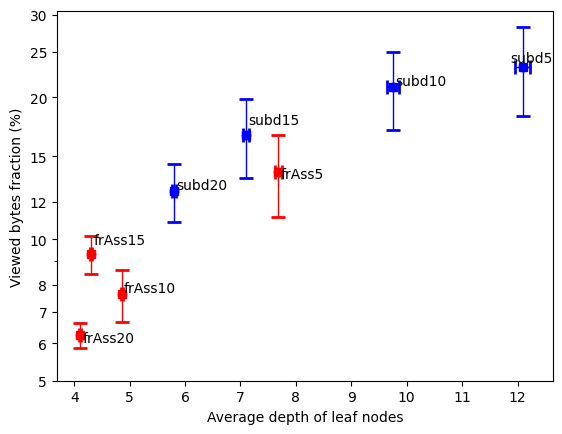

In [58]:
plotTreesComparison([
    ("frAss5", frAss5Path, "red"),
    ("frAss10", mastgTreesPath / "fr_as_sb_10", "red"), 
    ("frAss15", mastgTreesPath / "fr_as_sb_15", "red"),
    ("frAss20", frAss20Path, "red"),
    ("subd5", subd5Gpt4Path, "blue"),
    ("subd10", subd10Gpt4Path, "blue"),
    ("subd15", subd15Gpt4Path, "blue"),
    ("subd20", subd20Gpt4Path, "blue")],
    mePath / "comparison.svg", 
    mePath / "comparison.pdf",
    yticks = [5, 6, 7, 8, 10, 12, 15, 20, 25, 30])